In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd
from tqdm.notebook import tqdm
import h5py
import random
from sklearn.model_selection import GroupKFold
from sklearn.metrics import precision_score, recall_score, f1_score
import lightgbm as lgb
import warnings
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
from scipy.io import loadmat

In [2]:
ZSCORE_FEATURE = True

# note: we not just use SAMPLE_RANDON_SEED to control the randomness, but also use RANDOM_SELECT_SAMPLES.
RANDOM_SELECT_SAMPLES = True   # True
SAMPLE_MIN = 0.7               # 0.7 
SAMPLE_MAX = 1.0               # 1.0
SAMPLE_RANDOM_SEED = 42        # 
 
MANUAL_SET_TEST = True          # False
EXCLUDE_220 = False             # True

PRINT_NULL_IMP_CV_RESULT = False
CHECK_XENTROPY_TH = False      # False

NULL_IMP_RUNS = 100
NULL_STD = 3                 

mice = ['ym212','ym213','ym214','ym215','ym218','ym219','ym220','ym222','ym223','ym224','ym226','ym227']  # 12 in total
data_dir = r'D:/Yuichi/MemoryAge_WinLen_5_Step_0.5_FREEZING_ONLY/Data/DATA_win_len_5__step_0.5/'
sessions = ['RECENT','REMOTE']
feature_names = ['ACC_theta_power', 'CA1_theta_power', 'BLA_theta_power',
                 'ACC_beta_power', 'CA1_beta_power', 'BLA_beta_power',
                 'ACC_sGamma_power', 'CA1_sGamma_power', 'BLA_sGamma_power',
                 'ACC_fGamma_power', 'CA1_fGamma_power', 'BLA_fGamma_power']

In [3]:
def null_feature_importance(train_x, train_y, feature_names, n_estimators, n_runs, importance_type):
    '''
    train_x: train_FEATURES,       for example, shape=(4114, 24), type=numpy.ndarray
    train_y: train_TARGETS.copy(), for example, shape=(4114,), type=numpy.ndarray
    feature_names: 
    n_estimators: the average of best_iteration_all = ~ 200
    n_runs: how many times do you want to train the model with shuffle targets (in order to build a null distribution)
    importance_type: 'gain' or 'split'
    '''
    
    # Set hyperparameters
    params_shuffle = {
        'objective': 'xentropy',    # 'binary'
        'metric': 'xentropy',       # 'binary_logloss'
        'boosting_type': 'gbdt',    # 'gbdt'
        'learning_rate': 0.01,
        'num_leaves': 31,
        'max_depth': 6,
        'n_estimators': n_estimators,
        'verbose':-1,
    }

    null_feature_importance_df = pd.DataFrame()
    null_feature_importance_df['feature'] = feature_names

    null_fea_imp_list = []
    for run_idx in range(n_runs):
        # we can't shuffle train_y directly, since train_y is only a reference of the train_TARGETS
        train_y_shuffle = train_y.copy()
        # shuffle the target in-place
        np.random.shuffle(train_y_shuffle)

        lgb_train = lgb.Dataset(train_x, train_y_shuffle)

        # Train the model
        model_shuffle = lgb.train(params = params_shuffle, 
                                  train_set = lgb_train,
                                  verbose_eval = -1)
        
        df_tmp = pd.DataFrame()
        df_tmp['Run'+str(run_idx)] = model_shuffle.feature_importance(importance_type=importance_type)
        null_fea_imp_list.append(df_tmp)

    null_feature_importance_df['null_mean'] = np.mean(pd.concat(null_fea_imp_list, axis=1), axis=1)
    null_feature_importance_df['null_std'] = np.std(pd.concat(null_fea_imp_list, axis=1), axis=1)

    return null_feature_importance_df

In [4]:
def test_each_mouse_in_turn(Dataset, train_valid_mice, test_mice, feature_names, test_acc_all_mice, test_f1_all_mice, test_fea_imp_all_mice, test_f1_shuffled_all_mice):

    train_valid_df = Dataset.loc[Dataset['mouse_name'].isin(train_valid_mice), :].reset_index(drop=True)
    test_df = Dataset.loc[Dataset['mouse_name'].isin(test_mice), :].reset_index(drop=True)

    train_valid_FEATURES = np.array(train_valid_df.loc[:, feature_names])
    train_valid_TARGETS = np.array(train_valid_df.loc[:, 'target'])
    train_valid_GROUPS = np.array(train_valid_df.loc[:, 'mouse_name'])

    test_FEATURES = np.array(test_df.loc[:, feature_names])
    test_TARGETS = np.array(test_df.loc[:, 'target'])

    # CV
    gkf = GroupKFold(n_splits=5)
    accuracy_all = []         # all validation accuracy for each fold
    f1_all = []               # all validation f1 for each fold
    best_iteration_all = []   # best early stopping iteration for each fold

    for fold, (train_idx, validation_idx) in enumerate(gkf.split(train_valid_FEATURES, train_valid_TARGETS, groups=train_valid_GROUPS)):

        train_FEATURES = train_valid_FEATURES[train_idx, :]
        train_TARGETS = train_valid_TARGETS[train_idx]
        valid_FEATURES = train_valid_FEATURES[validation_idx, :]
        valid_TARGETS = train_valid_TARGETS[validation_idx]

        lgb_train = lgb.Dataset(train_FEATURES, train_TARGETS)
        lgb_val = lgb.Dataset(valid_FEATURES, valid_TARGETS)

        # Set hyperparameters
        params = {
            'objective': 'xentropy',    # 'binary'
            'metric': 'xentropy',       # 'binary_logloss'
            'boosting_type': 'gbdt',    # 'gbdt'
            'learning_rate': 0.01,
            'num_leaves': 31,
            'max_depth': 6,
            'n_estimators': 1000,
            'verbose':-1,
        }

        # Ignore UserWarnings
        warnings.filterwarnings('ignore', category=UserWarning)

        # ---------- Train the model
        model = lgb.train(params = params, 
                        train_set = lgb_train, 
                        valid_sets = [lgb_train, lgb_val],
                        early_stopping_rounds = 100,
                        verbose_eval = -1)
        
        # early stopping best iterations
        best_iteration_all.append(model.best_iteration)

        # ---------- Evaluate the model
        valid_pred_RAW = model.predict(valid_FEATURES)
        valid_pred = np.round(valid_pred_RAW)
        accuracy = np.mean(valid_pred == valid_TARGETS)
        accuracy_all.append(accuracy)

        # ----------check the distribution of the xentropy prob,
        #           then we can decide the classification TH
        if CHECK_XENTROPY_TH:
            plt.figure(figsize=(6,3))
            count, bin_edge, _ = plt.hist(x=valid_pred_RAW, bins=100)
            plt.title(f'Fold_{fold}, The distri of \'the prob to be Class1\' for all the validation cases. ')
            plt.xlim([0,1])
            plt.show()

            tot_num_valid_samples = count.sum()
            count_accumulate = 0
            for bin_idx, tmp in enumerate(count):
                count_accumulate += tmp
                if count_accumulate > tot_num_valid_samples/2:
                    classify_th = bin_edge[bin_idx]
                    break
        
        # ---------- NULL importance analysis
        # null feature importance
        null_feature_importance_df = null_feature_importance(train_x=train_FEATURES, 
                                                            train_y=train_TARGETS, 
                                                            feature_names=feature_names, 
                                                            n_estimators=200, 
                                                            n_runs=20, 
                                                            importance_type='split')

        # actual feature importance
        feature_importance_df = pd.DataFrame()
        feature_importance_df['feature'] = feature_names
        feature_importance_df['actual_importance'] = model.feature_importance()

        # FIND THE ACTUAL USEFUL FEATURES THAT AGAINST THE NOISE TARGETS!!!
        feature_importance_ALL = feature_importance_df.merge(null_feature_importance_df, how='left', left_on='feature', right_on='feature')
        feature_importance_ALL['usuful_feature_TH'] = feature_importance_ALL['null_mean'] + feature_importance_ALL['null_std']*NULL_STD
        feature_importance_ALL['NET_feature_importance'] = feature_importance_ALL['actual_importance'] - feature_importance_ALL['usuful_feature_TH']

        feature_importance_ALL = feature_importance_ALL.sort_values(by='NET_feature_importance', ascending=False)
        feature_importance_ALL.drop(['actual_importance','null_mean','null_std','usuful_feature_TH'], axis=1, inplace=True)
        feature_importance_ALL = feature_importance_ALL.loc[feature_importance_ALL['NET_feature_importance']>0, :].reset_index(drop=True)

        # ---------- precision, recall, F1
        precision = precision_score(valid_TARGETS, valid_pred, average='macro')
        recall = recall_score(valid_TARGETS, valid_pred, average='macro')
        f1 = f1_score(valid_TARGETS, valid_pred, average='macro')
        f1_all.append(f1)
        # note that 'macro' calculates the metric for each class independently and 
        # then takes the average across all classes. Each class is given equal weight.

        test_acc_all_mice.loc[test_acc_all_mice['fold']==str(fold+1), test_mice[0]] = np.round(accuracy,3)
        test_f1_all_mice.loc[test_f1_all_mice['fold']==str(fold+1), test_mice[0]] = np.round(f1,3)
    
    # mean accuracy and f1 for all the folds
    test_acc_all_mice.loc[test_acc_all_mice['fold']=='mean', test_mice[0]] = np.round(np.mean(accuracy_all),3)
    test_f1_all_mice.loc[test_f1_all_mice['fold']=='mean', test_mice[0]] = np.round(np.mean(f1_all),3)

    # --------------------------- test ----------------------------
    # Set hyperparameters
    infer_params = {
        'objective': 'xentropy',    # 'binary'
        'metric': 'xentropy',       # 'binary_logloss'
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 31,
        'max_depth': 8,
        'n_estimators': int(np.mean(best_iteration_all)),    # inherit from the CROSS VALIDATION ABOVE
        'verbose':-1,
    }

    lgb_infer = lgb.Dataset(train_valid_FEATURES, train_valid_TARGETS)

    # Train the model
    model_infer = lgb.train(params = infer_params, 
                            train_set = lgb_infer, 
                            verbose_eval=-1)

    # Predict the test set
    test_pred = model_infer.predict(test_FEATURES)
    test_pred = np.round(test_pred)
    # ---------------------------- shuffled baseline ----------------------------
    # shuffle the train_valid_TARGETS, and save it as a new variable
    train_valid_Shuffled_TARGETS = train_valid_TARGETS.copy()
    np.random.shuffle(train_valid_Shuffled_TARGETS)
    lgb_shuffled_infer = lgb.Dataset(train_valid_FEATURES, train_valid_Shuffled_TARGETS)

    # Train the model
    model_shuffled_infer = lgb.train(params = infer_params, 
                                     train_set = lgb_shuffled_infer, 
                                     verbose_eval=-1)
    # Predict the test set
    test_shuffled_pred = model_shuffled_infer.predict(test_FEATURES)
    test_shuffled_pred = np.round(test_shuffled_pred)

    test_shuffled_f1 = f1_score(test_TARGETS,  test_shuffled_pred, average='macro')

    test_f1_shuffled_all_mice.loc[test_f1_shuffled_all_mice['fold']=='test', test_mice[0]] = np.round(test_shuffled_f1,3)

    # ---------- accuracy, precision, recall, F1
    test_accuracy = np.mean(test_pred == test_TARGETS)
    test_precision = precision_score(test_TARGETS, test_pred, average='macro')
    test_recall = recall_score( test_TARGETS,  test_pred, average='macro')
    test_f1 = f1_score(test_TARGETS,  test_pred, average='macro')
    # note that 'macro' calculates the metric for each class independently and 
    # then takes the average across all classes. Each class is given equal weight.

    test_acc_all_mice.loc[test_acc_all_mice['fold']=='test', test_mice[0]] = np.round(test_accuracy,3)
    test_f1_all_mice.loc[test_f1_all_mice['fold']=='test', test_mice[0]] = np.round(test_f1,3)

    # ---------- NULL importance analysis
    null_fea_imp_df_test = null_feature_importance(train_x=train_valid_FEATURES, 
                                                train_y=train_valid_TARGETS, 
                                                feature_names=feature_names, 
                                                n_estimators=int(np.mean(best_iteration_all)),
                                                n_runs=NULL_IMP_RUNS,               # run the model 1000 times to build a null distribution
                                                importance_type='split')

    # actual feature importance
    fea_imp_df_test = pd.DataFrame()
    fea_imp_df_test['feature'] = feature_names
    fea_imp_df_test['actual_importance'] = model_infer.feature_importance()

    # FIND THE ACTUAL USEFUL FEATURES THAT AGAINST THE NOISE TARGETS!!!
    fea_imp_ALL_test = fea_imp_df_test.merge(null_fea_imp_df_test, how='left', left_on='feature', right_on='feature')

    fea_imp_ALL_test['significant_TH'] = fea_imp_ALL_test['null_mean'] + fea_imp_ALL_test['null_std']*NULL_STD
    fea_imp_ALL_test['NET_feature_importance'] = fea_imp_ALL_test['actual_importance'] - fea_imp_ALL_test['significant_TH']
    # set all the negative values to 0
    fea_imp_ALL_test.loc[fea_imp_ALL_test['NET_feature_importance']<0, 'NET_feature_importance'] = 0
    # normalize the feature importance
    fea_imp_ALL_test['NET_feature_importance'] = fea_imp_ALL_test['NET_feature_importance']/fea_imp_ALL_test['NET_feature_importance'].sum()
    # only keep columns 'feature' and 'NET_feature_importance'
    fea_imp_ALL_test = fea_imp_ALL_test.loc[:, ['feature', 'NET_feature_importance']]

    # rename NET_feature_importance to the mouse name
    fea_imp_ALL_test.rename(columns={'NET_feature_importance':test_mice[0]}, inplace=True)

    # merge
    test_fea_imp_all_mice = test_fea_imp_all_mice.merge(fea_imp_ALL_test, how='left', left_on='feature', right_on='feature')

    return test_acc_all_mice, test_f1_all_mice, test_fea_imp_all_mice, test_f1_shuffled_all_mice

# 1. Load and construct a dataset for modeling

In [5]:
Dataset = []
for mouse in tqdm(mice):
    for session in sessions:
        features_dir_tmp = data_dir + 'ALL_feature_vectors_' + session + '_' + mouse + '.mat'
        # feature_vectors_tmp = h5py.File(features_dir_tmp, 'r')
        feature_vectors_tmp = loadmat(features_dir_tmp)['ALL_feature_vectors']
        # feature_vectors_tmp = feature_vectors_tmp.get('ALL_feature_vectors')[()].transpose()  # type = numpy array, shape = (sample num, 24)
        
        # to exclude the corralation features
        feature_vectors_tmp = feature_vectors_tmp[:, 12:]

        feature_vectors_DF_tmp = pd.DataFrame(feature_vectors_tmp, columns=feature_names)
        feature_vectors_DF_tmp['mouse_name'] = mouse

        if session == 'RECENT':
            feature_vectors_DF_tmp['target'] = 0
        else:
            feature_vectors_DF_tmp['target'] = 1

        Dataset.append(feature_vectors_DF_tmp)

Dataset = pd.concat(Dataset, axis=0).reset_index(drop=True)

  0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
if ZSCORE_FEATURE:
    Dataset_Zscore = Dataset.groupby(['mouse_name']).transform(func=zscore, axis=0)
    # axis=0: If 0 or ‘index’: apply function to each column

    Dataset_Zscore['target'] = Dataset['target']
    Dataset_Zscore['mouse_name'] = Dataset['mouse_name']

    Dataset = Dataset_Zscore.copy()
    del Dataset_Zscore

In [7]:
# I want to randomly select samples from each mouse
# Each mouse has itsself sampling rate, which is SAMPLE_PERCENT.
# In fact, if you don't do this, it is fine. I want to do it
# beacuse I want to give the num of samples from each mouse some randoness.
# Then, groupKFold will not always give us the same grouping strategy.
if RANDOM_SELECT_SAMPLES:

    Sampled_data_all = []
    for mouse in mice:
        # give a fixed random seed for reproducibility
        np.random.seed(SAMPLE_RANDOM_SEED)
        SAMPLE_PERCENT = np.random.uniform(SAMPLE_MIN, SAMPLE_MAX)

        Sampled_data_tmp = Dataset.loc[Dataset['mouse_name']==mouse, :].sample(frac=SAMPLE_PERCENT, axis=0, random_state=SAMPLE_RANDOM_SEED)
        Sampled_data_all.append(Sampled_data_tmp)

    Dataset = pd.concat(Sampled_data_all).reset_index(drop=True)

In [8]:
test_acc_all_mice = pd.DataFrame(columns=['fold'] + mice)
test_acc_all_mice['fold'] = ['1','2','3','4','5', 'mean', 'test']

test_f1_all_mice = pd.DataFrame(columns=['fold'] + mice)
test_f1_all_mice['fold'] = ['1','2','3','4','5', 'mean','test']

test_fea_imp_all_mice = pd.DataFrame(columns=['feature'])
test_fea_imp_all_mice['feature'] = feature_names

test_f1_shuffled_all_mice = pd.DataFrame(columns=['fold'] + mice)
test_f1_shuffled_all_mice['fold'] = ['test']

for test_mice in mice:

    # organize the train-validataion and test dataset
    test_mice = [test_mice]
    train_valid_mice = [mouse_tmp for mouse_tmp in mice if mouse_tmp not in test_mice+['ym220']]

    test_acc_all_mice, test_f1_all_mice, test_fea_imp_all_mice, test_f1_shuffled_all_mice = test_each_mouse_in_turn(Dataset=Dataset,
                                                                                         train_valid_mice=train_valid_mice,
                                                                                         test_mice=test_mice,
                                                                                         feature_names=feature_names,
                                                                                         test_acc_all_mice=test_acc_all_mice,
                                                                                         test_f1_all_mice=test_f1_all_mice,
                                                                                         test_fea_imp_all_mice=test_fea_imp_all_mice,
                                                                                         test_f1_shuffled_all_mice=test_f1_shuffled_all_mice)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	training's cross_entropy: 0.355571	valid_1's cross_entropy: 0.681486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	training's cross_entropy: 0.416185	valid_1's cross_entropy: 0.859073
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[391]	training's cross_entropy: 0.217457	valid_1's cross_entropy: 0.501237
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	training's cross_entropy: 0.570493	valid_1's cross_entropy: 0.707123
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	training's cross_entropy: 0.375184	valid_1's cross_entropy: 0.598446
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	training's cross_entropy: 0.338757	vali

In [9]:
# Calculate the mean and standard deviation for each row
test_fea_imp_all_mice.loc[:, 'mean'] = test_fea_imp_all_mice.iloc[:, 1:].mean(axis=1)
test_fea_imp_all_mice.loc[:, 'std'] = test_fea_imp_all_mice.iloc[:, 1:].std(axis=1)

# Filter out rows with non-zero mean values
df_non_zero = test_fea_imp_all_mice[test_fea_imp_all_mice['mean'] != 0]

# Sort the rows based on the mean value
df_sorted = df_non_zero.sort_values(by='mean', ascending=False)


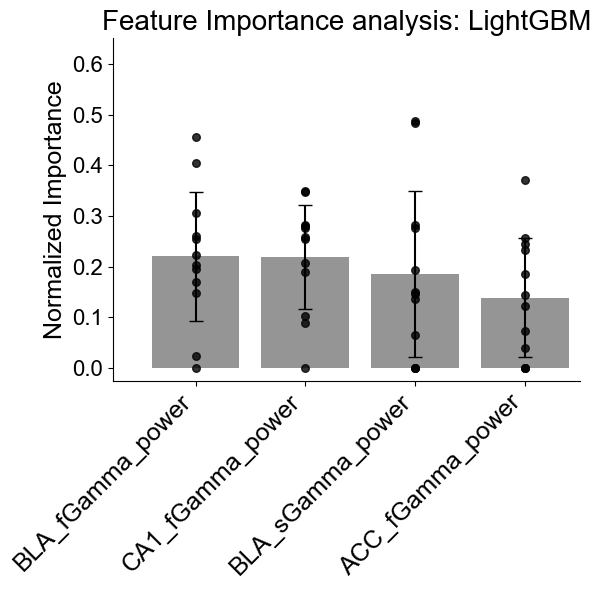

In [10]:
# Extracting the necessary data
features = df_sorted['feature'][:4]
means = df_sorted['mean'][:4]
stds = df_sorted['std'][:4]
mouse_data = df_sorted.iloc[:4, 1:13]

# Plotting
plt.figure(figsize=(6, 6))
color = sns.color_palette("Greys", 1) 

# Plotting the bars for mean values
bar_plot = plt.bar(features, means, yerr=stds, color=color, capsize=5)

# Plotting the raw data points for each feature
for i in range(mouse_data.shape[1]):
    plt.scatter(features, mouse_data.iloc[:, i], color='black', s=30, alpha=0.8)

# Adding labels and title
plt.ylabel('Normalized Importance', font='Arial', fontsize=18)
plt.xticks(rotation=45, ha='right', font='Arial', fontsize=18)
plt.yticks(font='Arial', fontsize=16)
plt.ylim([-0.025, 0.65])
plt.xlim([-0.75, 3.5])
plt.title('Feature Importance analysis: LightGBM', font='Arial', fontsize=20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Showing the plot
plt.tight_layout()
plt.show()

In [11]:
# for each row of the mouse_data, check the significance of the mean value against the zero baseline, using a statistical test
from scipy.stats import wilcoxon

results = {}
for feature_idx, feature in enumerate(features):
    # Wilcoxon signed-rank test for each feature compared to zero
    stat, p_value = wilcoxon(mouse_data.iloc[feature_idx, :] - 0)
    results[feature] = {'Statistic': stat, 'P-value': p_value}

results


{'BLA_fGamma_power': {'Statistic': 0.0, 'P-value': 0.0033456181158508813},
 'CA1_fGamma_power': {'Statistic': 0.0, 'P-value': 0.0033456181158508813},
 'BLA_sGamma_power': {'Statistic': 0.0, 'P-value': 0.007685794055213263},
 'ACC_fGamma_power': {'Statistic': 0.0, 'P-value': 0.007685794055213263}}

---

In [12]:
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon
import itertools

# Extracting the mouse data
mouse_data_only = df_sorted.iloc[:, 1:13]
feature_list = features.values.tolist()

# Calculating paired t-tests between each pair of features
pairs = list(itertools.combinations(range(len(features)), 2))  # Generating all possible pairs of features

result_tmp = []
for i, j in pairs:
    feature_1, feature_2 = feature_list[i], feature_list[j]
    t_statistic, p_value = wilcoxon(mouse_data_only.iloc[i], mouse_data_only.iloc[j])
    
    result_tmp.append([feature_1, feature_2, t_statistic, p_value])

pair_ttest_results = pd.DataFrame(result_tmp, columns=["Feature_1", "Feature_2", "T-Statistic", "P-Value"])

# Displaying the corrected results
pair_ttest_results.head(len(pair_ttest_results))  # Show all results


,Feature_1,Feature_2,T-Statistic,P-Value
0,BLA_fGamma_power,CA1_fGamma_power,38.0,0.969727
1,BLA_fGamma_power,BLA_sGamma_power,35.0,0.791016
2,BLA_fGamma_power,ACC_fGamma_power,9.0,0.032854
3,CA1_fGamma_power,BLA_sGamma_power,31.0,0.569336
4,CA1_fGamma_power,ACC_fGamma_power,23.0,0.233398
5,BLA_sGamma_power,ACC_fGamma_power,33.0,0.677246


In [13]:
test_f1_all_mice

,fold,ym212,ym213,ym214,ym215,ym218,ym219,ym220,ym222,ym223,ym224,ym226,ym227
0,1,0.547,0.535,0.589,0.677,0.539,0.607,0.517,0.407,0.152,0.629,0.671,0.498
1,2,0.411,0.35,0.431,0.574,0.313,0.444,0.441,0.738,0.784,0.474,0.474,0.335
2,3,0.749,0.772,0.764,0.716,0.102,0.775,0.769,0.443,0.47,0.732,0.756,0.716
3,4,0.451,0.548,0.517,0.681,0.671,0.558,0.549,0.695,0.69,0.497,0.475,0.37
4,5,0.658,0.561,0.544,0.633,0.623,0.566,0.541,0.681,0.64,0.599,0.69,0.592
5,mean,0.563,0.553,0.569,0.656,0.45,0.59,0.563,0.593,0.547,0.586,0.613,0.502
6,test,0.627,0.764,1.0,0.439,0.764,0.835,0.632,0.499,0.535,0.384,0.455,0.709


---

In [14]:
test_f1_shuffled_all_mice

,fold,ym212,ym213,ym214,ym215,ym218,ym219,ym220,ym222,ym223,ym224,ym226,ym227
0,test,0.568,0.69,0.333,0.423,0.413,0.457,0.553,0.168,0.349,0.412,0.449,0.516


In [17]:
# wilcoxon signed-rank test between test_f1_all_mice.loc[test_f1_all_mice['fold']=='mean'] and test_f1_shuffled_all_mice.loc[test_f1_shuffled_all_mice['fold']=='test']
from scipy.stats import wilcoxon
stat, p_value = wilcoxon(test_f1_all_mice.loc[test_f1_all_mice['fold']=='mean'].iloc[0, 1:], test_f1_shuffled_all_mice.loc[test_f1_shuffled_all_mice['fold']=='test'].iloc[0, 1:])
print(stat)
print(p_value)

10.0
0.02099609375
